# Imports

In [712]:
#Standard Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import warnings
warnings.filterwarnings(action='ignore') 

# Packages used for API calls and data processing
import requests
import json
def get_keys(path):
    with open(path) as f:
        return json.load(f)
import ast
import time
import http.client, urllib.request, urllib.parse, urllib.error, base64
api_key = 'ceeaacb7cf024c7485e00ef8457e42dc'
gamertag = 'Drymander'
from tqdm import tqdm
# !pip install isodate
import isodate

In [713]:
# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder


# Pull Player History

In [714]:
# Setting run equal to false.  If set to true, code will pull all matches for
# user in the gamertag variable
run = False


if run == True:
    # Setting API key and 'start' (0 means most recent match played)
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    start = 0
    matches = []
    
    # Condition to determine whether or not API call has exhausted full match history
    maxed_out = False
    
    # While loop that wil continuously pull from API and terminate once complete
    # When 'count' returns as 25, that means there are more matches to be pulled
    # When 'count' is less than 25, that indicates it is at the end of the player match history
    while maxed_out == False:
        try:
            params = urllib.parse.urlencode({
                # Request parameters
                'modes': 'arena',
                'start': start,
                'count': 25,
                'include-times': True,
            })
            # Code to process the API byte string into a JSON 
            # Will append each JSON to a list
            conn = http.client.HTTPSConnection('www.haloapi.com')
            conn.request("GET", f"/stats/h5/players/{gamertag}/matches?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            data = json.loads(data)
            matches.extend(data['Results'])
            conn.close()
            
            # If statement to detect final API call
            if data['ResultCount'] == 25:
                maxed_out = False
                time.sleep(1.1)
                start += 25
            else:
                maxed_out = True
        
        # Error handling
        except Exception as e:
            print("error")
    
    # Save to dataframe and CSV
    df = pd.DataFrame(matches)
    df.to_csv('DrymanderHistory.csv')



## Match History Exploration

In [715]:
# Read DrymanderHistory.csv, drop Unnamed: 0 column, show first row
df = pd.read_csv('DrymanderHistory.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head(1)

,Links,Id,HopperId,MapId,MapVariant,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,{'MatchId': '10010481-1be2-462b-9774-eac5ee152...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,"{'ResourceType': 3, 'ResourceId': 'beaccaff-81...",a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2


In [716]:
# Function to break out columns, many of which are nested dictionaries
def explode_column(df, column):
    # Convert column to string, locate column in dataframe, apply pd.Series
    # which breaks out the nested dictionaries as individual columns
    column = str(column)
    column_loc = df.columns.get_loc(column)
    column_split = df[column].apply(pd.Series)
    
    # Drop column with nested dictionaries and add back key / values as new columns
    df = df.drop(columns=[column])
    df = df.join(column_split, rsuffix=str(column))
    
    # Return dataframe
    return df

# Test function on 'Id' column
explode_column(df, 'Id').head(1)

,Links,HopperId,MapId,MapVariant,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,0
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,"{'ResourceType': 3, 'ResourceId': 'beaccaff-81...",a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,{'MatchId': '10010481-1be2-462b-9774-eac5ee152...


In [717]:
# Columns are read from csv as strings, this code converts them back to Python code
df['Id'] = df['Id'].map(ast.literal_eval)
# Explode Id column
df = explode_column(df, 'Id')
df.head(1)

,Links,HopperId,MapId,MapVariant,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,"{'ResourceType': 3, 'ResourceId': 'beaccaff-81...",a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1


In [718]:
# Convert strings to dictionaries and explode MapVariant
df['MapVariant'] = df['MapVariant'].map(ast.literal_eval)
df = explode_column(df, 'MapVariant')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,GameVariant,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,"{'ResourceType': 2, 'ResourceId': 'f213daf2-94...",PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,


In [719]:
# Convert strings to dictionaries and explode GameVariant
df['GameVariant'] = df['GameVariant'].map(ast.literal_eval)
df = explode_column(df, 'GameVariant')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,MatchCompletedDate,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,{'ISO8601Date': '2021-07-01T00:55:13.88Z'},"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,


In [720]:
# Convert strings to dictionaries and explode GameVariant MatchCompletedDate
df['MatchCompletedDate'] = df['MatchCompletedDate'].map(ast.literal_eval)
df = explode_column(df, 'MatchCompletedDate')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Teams,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Id': 1, 'Score': 1, 'Rank': 2}, {'Id': 0, '...","[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z


In [721]:
# Convert strings to dictionaries and explode GameVariant Teams
df['Teams'] = df['Teams'].map(ast.literal_eval)
df = explode_column(df, 'Teams')

df.head(1)

,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,0,1,2,3,4,5,6,7,8,9,10,11
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z,"{'Id': 1, 'Score': 1, 'Rank': 2}","{'Id': 0, 'Score': 2, 'Rank': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [722]:
# Convert strings to dictionaries and explode GameVariant Teams
df['Players'] = df['Players'].map(ast.literal_eval)
explode_column(df, 'Players').head(1)

# Handling 'Players' differently since it has nested dictionaries within nested dictionaries
# Breaking out 'Players'
df_players = df['Players'].apply(pd.Series)

# Converting the columns from integers to strings
df_players.columns = df_players.columns.astype(str)

# Exploding the '0' column as its own dataframe
df_players_explode = explode_column(df_players, '0')

# Exploding a more deeply nested 'Player' column
df_match_stats = explode_column(df_players_explode, 'Player')

# Appending results to main dataframe
df = df.join(df_match_stats, rsuffix='_stats')

df.head(1)


,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,0,1,2,3,4,5,6,7,8,9,10,11,TeamId,Rank,Result,TotalKills,TotalDeaths,TotalAssists,PreMatchRatings,PostMatchRatings,Gamertag,Xuid
0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,,2021-07-01T00:55:13.88Z,"{'Id': 1, 'Score': 1, 'Rank': 2}","{'Id': 0, 'Score': 2, 'Rank': 1}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,3,11,9,6,None,None,Drymander,None


In [723]:
df = pd.read_csv('DrymanderHistoryExplode.csv')
df.head(1)

,Unnamed: 0,Links,HopperId,MapId,GameBaseVariantId,MatchDuration,Players,IsTeamGame,SeasonId,MatchCompletedDateFidelity,MatchId,GameMode,ResourceType,ResourceId,OwnerType,Owner,ResourceTypeGameVariant,ResourceIdGameVariant,OwnerTypeGameVariant,OwnerGameVariant,ISO8601Date,2,3,4,5,6,7,8,9,10,11,Id,Score,Rank,Id1,Score1,Rank1,TeamId,Rank_stats,Result,TotalKills,TotalDeaths,TotalAssists,PreMatchRatings,PostMatchRatings,Gamertag,Xuid
0,0,{'StatsMatchDetails': {'AuthorityId': 'spartan...,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,d67fdcb9-6d9c-403e-960d-04202e19b244,a2949322-dc84-45ab-8454-cf94fb28c189,PT8M48.3224767S,"[{'Player': {'Gamertag': 'Drymander', 'Xuid': ...",True,NaN,2,10010481-1be2-462b-9774-eac5ee152045,1,3,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,3,NaN,2,f213daf2-94f9-46a4-a4d8-b3f782da0bec,3,NaN,2021-07-01T00:55:13.88Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2,0,2,1,0,2,3,11,9,6,NaN,NaN,Drymander,NaN


# Pull All Matches from Player Match History

In [724]:
# Setting run equal to false.  If set to true, code will pull all matches for
run = False

if run == True:
    
    # Setting API key
    headers = {
        # Request headers
        'Ocp-Apim-Subscription-Key': api_key,
    }
    params = urllib.parse.urlencode({
    })
    
    # Setting match_list to every MatchId in the player history dataframe
    match_list = df['MatchId']
    # Instantiating empty list to append API results
    match_details = []
    # Counter variable
    i = 0
    
    # This loop will pull extensive match details for every MatchId in the player
    # history dataframe and add each match to the match_details list
    for match in match_list:
        try:
            conn = http.client.HTTPSConnection('www.haloapi.com')
            conn.request("GET", f"/stats/h5/arena/matches/{match}?%s" % params, "{body}", headers)
            response = conn.getresponse()
            data = response.read()
            data = json.loads(data)
            match_details.append(data)
            conn.close()
            i += 1
            time.sleep(1.1)

        except Exception as e:
            print("error")

# If run == False, this will load previously compiled match_details from pickle
else: 
    with open('match_details.pkl', 'rb') as match_details:
        match_results = pickle.load(match_details)

# Show match details, should be 5903
len(match_results)

5903

In [725]:
# Saving our original datafarme as df_history
df_history = df.copy()

In [726]:
# Instantiating new dataframe
df = pd.DataFrame()

# Converting dates to a more readable format
df['Date'] = df_history['ISO8601Date']
df['Date'] = df['Date'].apply(pd.to_datetime)

# Adding MatchId from df_history
df['MatchId'] = df_history['MatchId']

df.head(5)

,Date,MatchId
0,2021-07-01 00:55:13.880000+00:00,10010481-1be2-462b-9774-eac5ee152045
1,2021-07-01 00:49:29.519000+00:00,d8964123-992f-4dd9-8555-40b76a98d4e1
2,2021-07-01 00:40:43.086000+00:00,c86a93e7-4842-4443-9b90-875b20e3846e
3,2021-07-01 00:32:49.388000+00:00,79379ee7-036c-4c4a-9945-ef6eec06fed8
4,2021-07-01 00:24:59.974000+00:00,f16ebbe7-3ddd-4ff8-92de-52904c282d26


# Compile Match Dataframe

In [727]:
# List of stats we want to collect from our list of match dictionaries
# These are player specific
inner_stats = [
            'TeamId',
            'Rank',
            'DNF',
            'AvgLifeTimeOfPlayer',
            'PlayerScore',
            'GameEndStatus',
            'TotalKills',
            'TotalHeadshots',
            'TotalWeaponDamage',
            'TotalShotsFired',
            'TotalShotsLanded',
            'TotalMeleeKills',
            'TotalMeleeDamage',
            'TotalAssassinations',
            'TotalGroundPoundKills',
            'TotalGroundPoundDamage',
            'TotalShoulderBashKills',
            'TotalShoulderBashDamage',
            'TotalGrenadeDamage',
            'TotalPowerWeaponKills',
            'TotalPowerWeaponDamage',
            'TotalPowerWeaponGrabs',
            'TotalPowerWeaponPossessionTime',
            'TotalDeaths',
            'TotalAssists',
            'TotalGamesCompleted',
            'TotalGamesWon',
            'TotalGamesLost',
            'TotalGamesTied',
            'TotalTimePlayed',
            'TotalGrenadeKills',
            'TotalSpartanKills',
              ]

# Stats collected for each game that are not player specific
outer_stats = [
            'TotalDuration',
            'MapVariantId',
            'GameVariantId',
            'PlaylistId',
            'MapVariantId',
            'GameBaseVariantId'
]

In [728]:
# New dataframe to compile match details
all_matches_df = pd.DataFrame()
# Setting match count which will help loop through the match list
match_count = 0

# Loop that will collect data by sifting through all JSONs in our match list
for match in tqdm(match_results):
    match_dic = {}
    i=0
    
    # Loop that identifies gamertag within match JSONs
    for player in match['PlayerStats']:
        if match['PlayerStats'][i]['Player']['Gamertag'] == gamertag:
            gamertag_stats = match['PlayerStats'][i]
        else:
            i += 1
    
    # Appending inner stats (gamertag specific)
    for stat in inner_stats:
        match_dic[stat] = gamertag_stats[stat]
    
    # Appending outer stats (match specific)
    for stat in outer_stats:
        match_dic[stat] = match[stat]
    
    # Create one row dataframe from appended stats
    single_match_df = pd.DataFrame.from_records([match_dic])
    # Append that one row dataframe to all_matches_df
    all_matches_df = all_matches_df.append(single_match_df, ignore_index=True)

# Adding date column and MatchId
all_matches_df['Date'] = df['Date'].apply(pd.to_datetime)
all_matches_df['MatchId'] = df_history['MatchId']

100%|██████████| 5903/5903 [01:12<00:00, 81.75it/s]


# Data Processing and Feature Creation 

In [731]:
# Making copy of all_matches_df so we can work with just df
df = all_matches_df.copy()

df.head(3)

,TeamId,Rank,DNF,AvgLifeTimeOfPlayer,PlayerScore,GameEndStatus,TotalKills,TotalHeadshots,TotalWeaponDamage,TotalShotsFired,TotalShotsLanded,TotalMeleeKills,TotalMeleeDamage,TotalAssassinations,TotalGroundPoundKills,TotalGroundPoundDamage,TotalShoulderBashKills,TotalShoulderBashDamage,TotalGrenadeDamage,TotalPowerWeaponKills,TotalPowerWeaponDamage,TotalPowerWeaponGrabs,TotalPowerWeaponPossessionTime,TotalDeaths,TotalAssists,TotalGamesCompleted,TotalGamesWon,TotalGamesLost,TotalGamesTied,TotalTimePlayed,TotalGrenadeKills,TotalSpartanKills,TotalDuration,MapVariantId,GameVariantId,PlaylistId,GameBaseVariantId,Date,MatchId
0,0,2,False,PT19.0101779S,0,3,11,1,1333.918901,231,66,1,80.029148,0,0,0.0,0,0.0,90.000000,9,1086.018900,0,PT2M24.6165S,9,6,0,0,0,0,PT4M50.4721844S,0,11,PT8M48.3224767S,beaccaff-8166-4fe8-94ba-fd18ad7a83e1,f213daf2-94f9-46a4-a4d8-b3f782da0bec,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,a2949322-dc84-45ab-8454-cf94fb28c189,2021-07-01 00:55:13.880000+00:00,10010481-1be2-462b-9774-eac5ee152045
1,0,2,False,PT27.334877S,14,3,14,0,1824.901194,259,87,2,198.000015,0,0,0.0,0,0.0,50.744907,11,1635.156286,0,PT5M14.0166S,12,1,0,0,0,0,PT7M27.8478311S,0,14,PT7M27.8508336S,8e4831a0-debb-4f4e-ae75-a0834edcb153,04a4099c-8b96-40a7-a341-668d94a10357,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,2021-07-01 00:49:29.519000+00:00,d8964123-992f-4dd9-8555-40b76a98d4e1
2,1,4,False,PT23.8690928S,10,3,10,2,1300.256462,196,47,0,0.000000,0,0,0.0,0,0.0,92.379814,9,1169.076649,0,PT4M8.3165S,12,3,0,0,0,0,PT6M35.1332077S,1,10,PT6M35.1342094S,b82c7fed-4667-43f8-8467-50741a5e1103,1005b609-aed9-4f19-bc3b-e8f0d29465f0,f0c9ef9a-48bd-4b24-9db3-2c76b4e23450,257a305e-4dd3-41f1-9824-dfe7e8bd59e1,2021-07-01 00:40:43.086000+00:00,c86a93e7-4842-4443-9b90-875b20e3846e


In [732]:
# Checking to see that all stats made it within the columns
df.columns

Index(['TeamId', 'Rank', 'DNF', 'AvgLifeTimeOfPlayer', 'PlayerScore',
       'GameEndStatus', 'TotalKills', 'TotalHeadshots', 'TotalWeaponDamage',
       'TotalShotsFired', 'TotalShotsLanded', 'TotalMeleeKills',
       'TotalMeleeDamage', 'TotalAssassinations', 'TotalGroundPoundKills',
       'TotalGroundPoundDamage', 'TotalShoulderBashKills',
       'TotalShoulderBashDamage', 'TotalGrenadeDamage',
       'TotalPowerWeaponKills', 'TotalPowerWeaponDamage',
       'TotalPowerWeaponGrabs', 'TotalPowerWeaponPossessionTime',
       'TotalDeaths', 'TotalAssists', 'TotalGamesCompleted', 'TotalGamesWon',
       'TotalGamesLost', 'TotalGamesTied', 'TotalTimePlayed',
       'TotalGrenadeKills', 'TotalSpartanKills', 'TotalDuration',
       'MapVariantId', 'GameVariantId', 'PlaylistId', 'GameBaseVariantId',
       'Date', 'MatchId'],
      dtype='object')

## Winner Column

In [733]:
df['WinLoseTie'] = df['GameEndStatus'].map({3:'Victory', 2:'Tie', 1:'Defeat', 0:'Did Not Finish'})

## Converting Time Codes

In [734]:
# List of columns we want to convert
time_columns = ['AvgLifeTimeOfPlayer', 'TotalTimePlayed', 'TotalDuration',
                'TotalPowerWeaponPossessionTime']

# Function to convert time columns into readable formate
def convert_times(df, time_columns):
    for column in time_columns:
        parsed_times = []
        for row in df[column]:
            row = isodate.parse_duration(row).total_seconds() / 60
            parsed_times.append(row)
        df[column] = parsed_times

# Converting time columns
convert_times(df, time_columns)

# Converting average lifetime of player from minute to seconds
df['AvgLifeTimeOfPlayer'] = df['AvgLifeTimeOfPlayer'] * 60

df[['AvgLifeTimeOfPlayer', 'TotalTimePlayed', 'TotalDuration',
    'TotalPowerWeaponPossessionTime']].head(3)

,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,TotalPowerWeaponPossessionTime
0,19.010178,4.841203,8.805375,2.410275
1,27.334877,7.464131,7.464181,5.233610
2,23.869093,6.585553,6.585570,4.138608


## Decoding GameBaseVariant, PlayListId, MapVariantId

In [735]:
# This function will convert codes provided by the API into a readable format
def decode_column(df, column, api_dict):
    decoded_list = []

    for row in df[column]:
        i = 0
        for item in api_dict:
            if item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            else:
                i += 1
    
    return decoded_list

In [736]:
# This function will convert maps to readable format
def decode_maps(df, column, api_dict):
    decoded_list = []

    for row in df[column]:
        i = 0
        map_count = len(api_dict)
        
        for item in api_dict:
            if (i+1) == map_count:
                name = 'Custom Map'
                decoded_list.append(name)
            elif item['id'] == row:
                name = item['name']
                decoded_list.append(name)
            else:
                i += 1
    
    return decoded_list

In [737]:
# Loading GameBaseVariantId metadata dictionary pulled from API
with open('GameBaseVariantId.pkl', 'rb') as GameBaseVariantId_pickle:
    GameBaseVariantId_dic = pickle.load(GameBaseVariantId_pickle)

# Loading PlaylistId metadata dictionary pulled from API
with open('PlaylistId_dic.pkl', 'rb') as PlaylistId_dic_pickle:
    PlaylistId_dic = pickle.load(PlaylistId_dic_pickle)

# Loading map_list metadata dictionary pulled from API
with open('map_list.pkl', 'rb') as map_list_pickle:
    map_list = pickle.load(map_list_pickle)

# Decode columsn with using our decode functions
df['GameBaseVariantId'] = decode_column(df, 'GameBaseVariantId', GameBaseVariantId_dic)    
df['PlaylistId'] = decode_column(df, 'PlaylistId', PlaylistId_dic)
df['MapVariantId'] = decode_maps(df, 'MapVariantId', map_list)

df[['GameBaseVariantId', 'PlaylistId', 'MapVariantId']].head(3)

,GameBaseVariantId,PlaylistId,MapVariantId
0,Capture the Flag,Super Fiesta Party,Traverse
1,Slayer,Super Fiesta Party,Vestige
2,Slayer,Super Fiesta Party,Russet


## K/D and Accuracy Columns

In [738]:
# Creating columns that are useful in understanding player skill
df['K/D'] = df['TotalKills'] / df['TotalDeaths']
df['Accuracy'] = df['TotalShotsLanded'] / df['TotalShotsFired']

df[['K/D', 'Accuracy']]

,K/D,Accuracy
0,1.222222,0.285714
1,1.166667,0.335907
2,0.833333,0.239796
3,1.187500,0.348668
4,0.200000,0.434211
...,...,...
5898,0.272727,0.122530
5899,0.125000,0.243243
5900,0.384615,0.326316
5901,0.294118,0.228365


In [739]:
# Organizing columns in an order that makes sense
df_columns = ['Date',
            'DNF',
            'GameBaseVariantId',
            'PlaylistId',
            'MapVariantId',
            'WinLoseTie',
            'TotalKills',
            'TotalDeaths',
            'K/D',
            'Accuracy',
            'TotalHeadshots',
            'TotalWeaponDamage',
            'TotalGrenadeKills',
            'TotalGrenadeDamage',
            'AvgLifeTimeOfPlayer',
            'TotalTimePlayed',
            'TotalDuration',
            'MatchId',
             ]

df = df[df_columns]

df.head(2)

,Date,DNF,GameBaseVariantId,PlaylistId,MapVariantId,WinLoseTie,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,MatchId
0,2021-07-01 00:55:13.880000+00:00,False,Capture the Flag,Super Fiesta Party,Traverse,Victory,11,9,1.222222,0.285714,1,1333.918901,0,90.000000,19.010178,4.841203,8.805375,10010481-1be2-462b-9774-eac5ee152045
1,2021-07-01 00:49:29.519000+00:00,False,Slayer,Super Fiesta Party,Vestige,Victory,14,12,1.166667,0.335907,0,1824.901194,0,50.744907,27.334877,7.464131,7.464181,d8964123-992f-4dd9-8555-40b76a98d4e1


## Removing Unnecessary Rows

In [740]:
# Removing rows where 'DNF' is true (or where player 'Did Not Finish' the match)
df = df.loc[df['DNF'] == False]

df['DNF'].value_counts()

False    5732
Name: DNF, dtype: int64

# Visualizations

## Win / Loss / Tie by Month

In [521]:
# Setting a copy of df which will be easy to revert to without rerunning all code above
df_predate = df.copy()

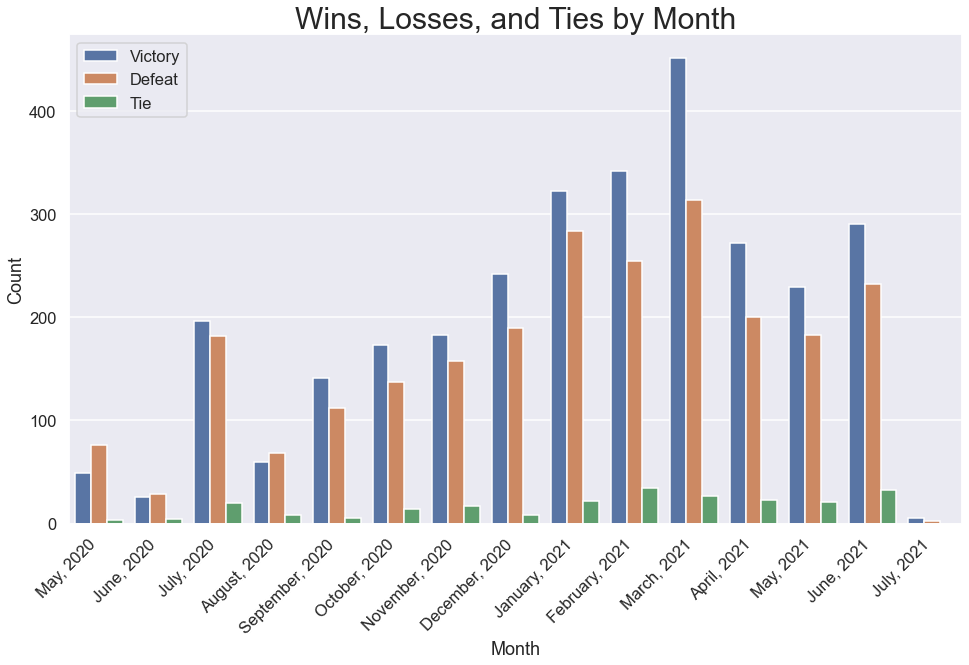

In [761]:
# Loading from copy
df = df_predate.copy()

# Setting seaborn styles
sns.set(rc={'axes.facecolor':'white'})
sns.set_style("darkgrid")
sns.set_context('talk')

# Creating 'Month' column
df['Month'] = pd.to_datetime(df['Date']).dt.to_period('M')
df['Month'] = df['Month'].dt.strftime('%B, %Y')

# Setting time frame of data to visualize
df = df[(df['Date'] > '2020-05-01')]

# Instantiating graph and countplot
f, ax = plt.subplots(figsize=(16, 9))
ax = sns.countplot(x="Month", 
                   data=df.sort_values(by=['Date'], ascending=True), 
                   hue='WinLoseTie',
                   hue_order=['Victory','Defeat','Tie'])

# Setting xtick labels, axis titles, plot titles, and legend order
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, horizontalalignment='right');
ax.set_title('Wins, Losses, and Ties by Month', fontsize=30)
ax.set(ylabel='Count')
plt.legend(labels=['Victory', 'Defeat', 'Tie'])

# Reverting back to original df for convenience with the next visualization
df = df_predate.copy()

# Win Rate by Map

In [749]:
# Creating new columns which will be used for counting wins and losses
df['Win'] = df['WinLoseTie'].map({'Victory':1})
df['Lose'] = df['WinLoseTie'].map({'Defeat':1})

In [750]:
# Function that will filter dataframe by GameBaseVariant and PlaylistId
def choose_gametype(df, GameBaseVariantId, PlaylistId):
    if GameBaseVariantId == None and PlaylistId == None:
        gametype_df = df
    elif GameBaseVariantId == None:
        gametype_df = df[df['PlaylistId'] == PlaylistId]
    elif PlaylistId == None:
        gametype_df = df[df['GameBaseVariantId'] == GameBaseVariantId]
    else:
        gametype_df = df[(df['GameBaseVariantId'] == GameBaseVariantId) & (df['PlaylistId'] == PlaylistId)]
    
    return gametype_df

# Creating new dataframes for husky raid and slayer
husky_df = choose_gametype(df, 'Capture the Flag', 'Super Fiesta Party')
slayer_df = choose_gametype(df, 'Slayer', 'Super Fiesta Party')

In [751]:
# Creating dataframe grouped by WinRate and sum
husky_gb_sum = husky_df.groupby( ["MapVariantId"] ).sum()
husky_gb_sum.reset_index(level=0, inplace=True)
husky_gb_sum['WinRate'] = husky_gb_sum['Win'] / husky_gb_sum['Lose']
husky_gb_sum = husky_gb_sum[~husky_gb_sum.isin([np.nan, np.inf, -np.inf]).any(1)]

husky_gb_sum.head(3)

,MapVariantId,DNF,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,Win,Lose,WinRate
0,Blood and Stone,0,1964,2602,157.997519,75.339873,136,252318.403049,43,11589.676155,2531.67524,866.854687,868.907452,110.0,71.0,1.549296
1,Classified,0,1861,1756,103.897660,40.778846,71,235956.888552,32,8005.991636,1460.22443,659.792479,659.825388,40.0,28.0,1.428571
3,Containment Breach,0,1213,1468,76.050042,35.318265,59,151842.806095,18,6353.467373,1459.76296,575.038938,575.070256,43.0,35.0,1.228571


In [752]:
# Creating dataframe grouped by WinRate and mean
husky_gb_mean = husky_df.groupby( ["MapVariantId"] ).mean()
husky_gb_mean.reset_index(level=0, inplace=True)
husky_gb_mean['WinRate'] = husky_gb_mean['Win'] / husky_gb_mean['Lose']
husky_gb_mean = husky_gb_mean[~husky_gb_mean.isin([np.nan, np.inf, -np.inf]).any(1)]

husky_gb_mean.head(3)

,MapVariantId,DNF,TotalKills,TotalDeaths,K/D,Accuracy,TotalHeadshots,TotalWeaponDamage,TotalGrenadeKills,TotalGrenadeDamage,AvgLifeTimeOfPlayer,TotalTimePlayed,TotalDuration,Win,Lose,WinRate
0,Blood and Stone,False,10.791209,14.296703,0.868118,0.413955,0.747253,1386.364852,0.236264,63.679539,13.910304,4.762938,4.774217,1.0,1.0,1.0
1,Classified,False,20.450549,19.296703,1.141733,0.448119,0.780220,2592.932841,0.351648,87.977930,16.046422,7.250467,7.250828,1.0,1.0,1.0
3,Containment Breach,False,13.942529,16.873563,0.874138,0.405957,0.678161,1745.319610,0.206897,73.028361,16.778885,6.609643,6.610003,1.0,1.0,1.0


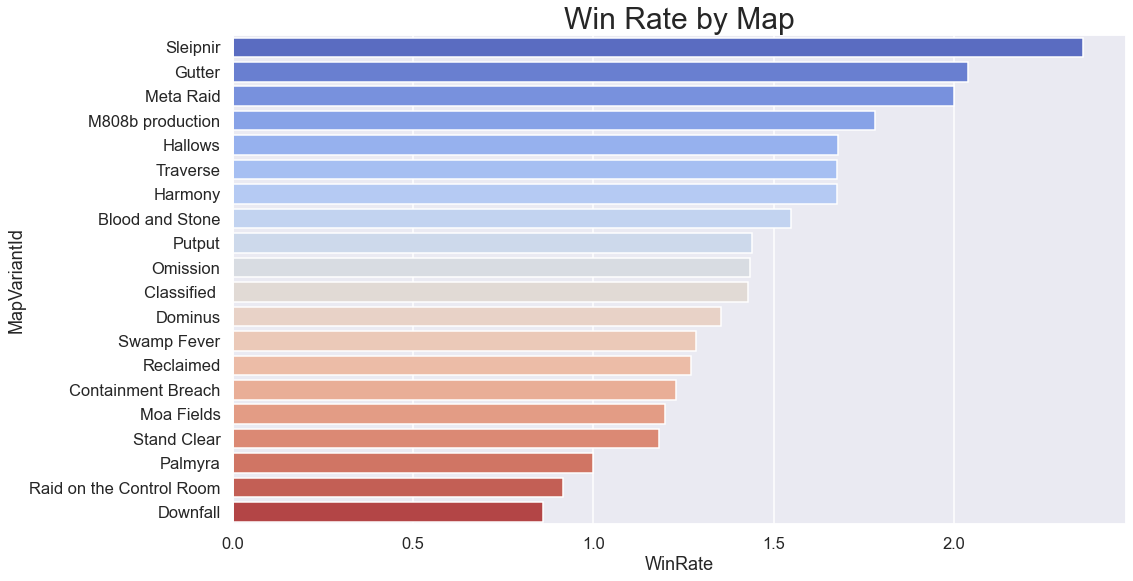

In [768]:
# Function to show column stat broken out by map
def map_plot(df, column, title, x_range=False):
    
    # Initiate seaborn barplot that will sort in descending order from best to worst
    # stat on each map
    f, ax = plt.subplots(figsize=(16, 9))
    ax = sns.barplot(x=column, y='MapVariantId', data=df, 
                order=df.sort_values(column, ascending=False).MapVariantId, 
                palette=('coolwarm'))
    ax.set_title(title, fontsize=30)
    
    # Option to set x axis range within function parameters
    if x_range == False:
        pass
    else:
        ax.set_xlim(x_range[0],x_range[1])

# Plot win rate by map
map_plot(husky_gb_sum, 'WinRate', 'Win Rate by Map')

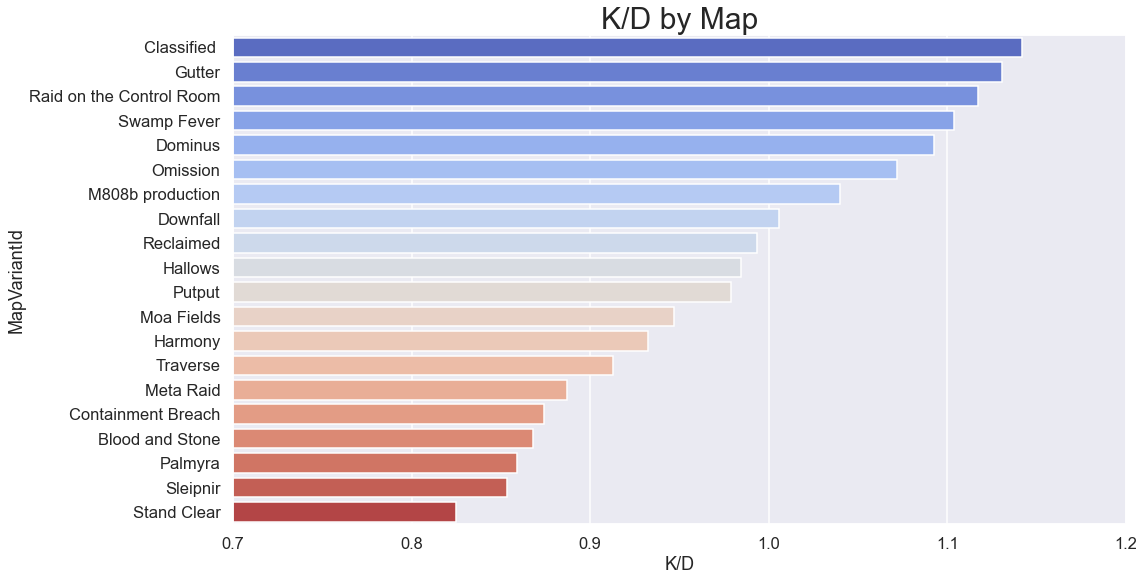

In [772]:
# Plot K/D per map with a range of 0.7-1.2
map_plot(husky_gb_mean, 'K/D', 'K/D by Map', x_range=[0.7,1.2])

# K/D Date

In [773]:
# Setting a copy of df which will be easy to revert to without rerunning all code above
df_kd = df.copy()

In [810]:
# df = df_kd.copy()
# df['Day'] = df['Date'].dt.date
# df['Day'] = df['Day'].apply(pd.to_datetime)
# df_gb_mean = df.groupby(['Day']).mean()
# _grouped = df_gb_mean[column_list].rolling('30D').mean()
# df_gb_mean = pd.DataFrame(_grouped)
# df_gb_mean.index.dt.strftime('%b-%Y')


<AxesSubplot:title={'center':'K/D Over Time'}, xlabel='Date', ylabel='Count of Kills / Deaths'>

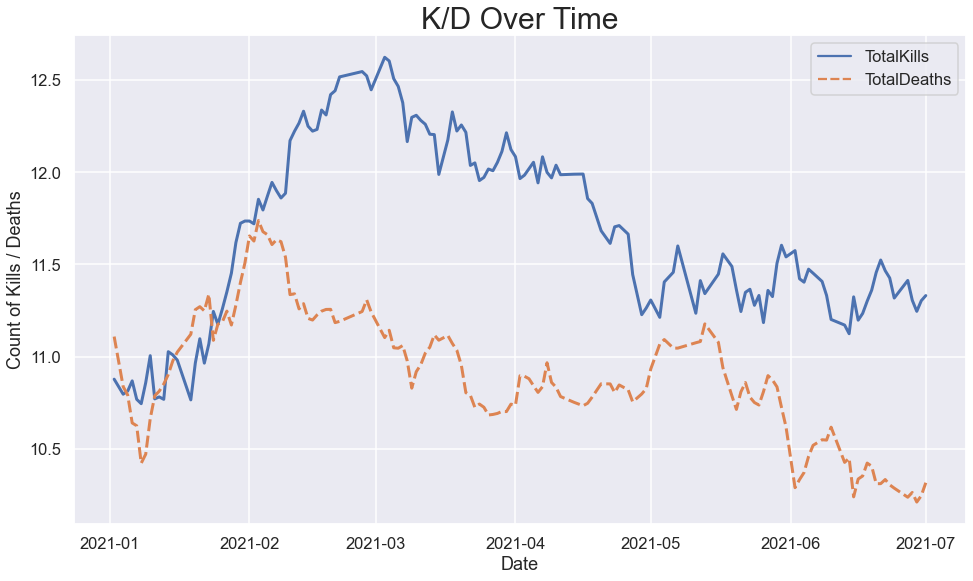

In [811]:
# Reloading dataframe from copy
df = df_kd.copy()

# Function to create line plot for any given column stat in the 'slayer' playlist
# using rolling days smoothing
def stat_lineplot(df, column_list, title, rolling_days=30):
    
    # Choosing 'slayer' gametype
    df = choose_gametype(df, 'Slayer', None)
    # Creating 'Day' column
    df['Day'] = df['Date'].dt.date
    df['Day'] = df['Day'].apply(pd.to_datetime)
    
    # Creating groupby dataframe using 'Day' column and implementing rolling days
    # averaging
    df_gb_mean = df.groupby(['Day']).mean()
    _grouped = df_gb_mean[column_list].rolling(f'{rolling_days}D').mean()
    df_gb_mean = pd.DataFrame(_grouped)
    
    # Isolating time frame
    df_gb_mean = df_gb_mean[((df_gb_mean.index > '2021-01-01') & (df_gb_mean.index > '2020-06-30'))]
    
    # Creating line plot
    f, ax = plt.subplots(figsize=(16, 9))
    ax = sns.lineplot(data=df_gb_mean, linewidth = 3)
    plt.xlabel('Date')
    ax.set(ylabel='Count of Kills / Deaths')
#     x_tick_labels = pd.to_datetime(df_gb_mean.index, format = "%m%Y")
#     ax.set_xticklabels(x_tick_labels, rotation=45, horizontalalignment='right');
    ax.set_title(title, fontsize=30)
    
    return ax;
    
column_list = ['TotalKills', 'TotalDeaths']
stat_lineplot(df, column_list, 'K/D Over Time', rolling_days=30)

<AxesSubplot:title={'center':'Headshot Average Over Time'}, xlabel='Date', ylabel='Count of Kills / Deaths'>

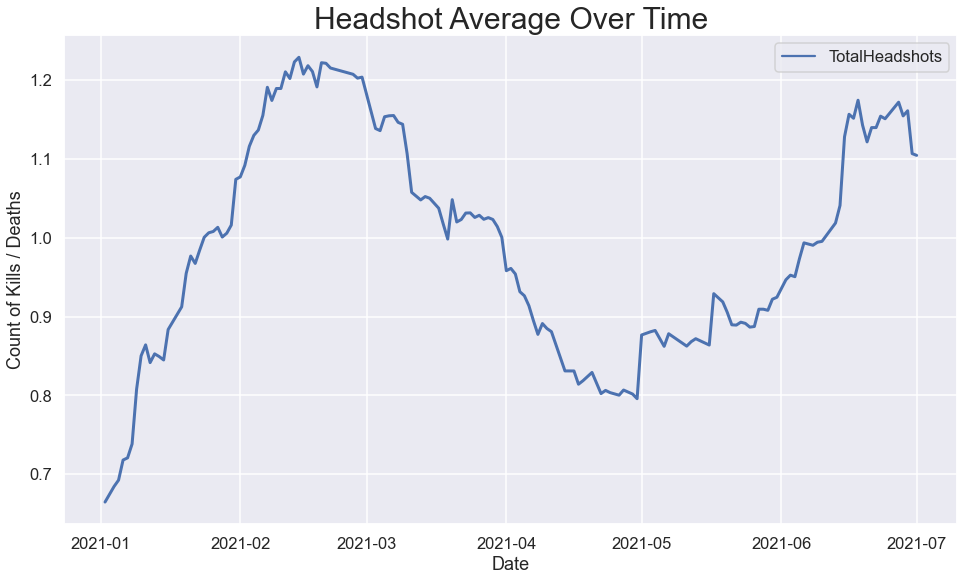

In [812]:
column_list = ['TotalHeadshots']

stat_lineplot(df, column_list, 'Headshot Average Over Time', rolling_days=60)